<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/reduced_version_lstm_ae_(1_layer)_viridae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

# Read Data

In [5]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/viridae/'
filename = 'reduced_viridae.csv'
records_df = pd.read_csv(data_path + filename)
records_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# replace all '-' with N (stands for any nt)
# records_df.seq = records_df.seq.str.replace('-', 'N')
records_df.head()

,id,seq,label,ngram
0,NC_000947.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
1,NC_001366.1,NNNNNNNNNNTTGAAAGGGGGCCCGGGGGNNNNNNNNNNNNNNNAC...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
2,NC_001430.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
3,NC_001445.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
4,NC_001472.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."


In [6]:
seq_num = 0
for seq in records_df["seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G' and char != 'N':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

seq 50 char 973 is Y
seq 182 char 1399 is R
seq 264 char 2084 is R
seq 264 char 2327 is R


In [7]:
records_df.seq = records_df.seq.str.replace('R', 'A')
records_df.seq = records_df.seq.str.replace('Y', 'T')

In [8]:
# check if the length of the sequence is the same 
seq_len = len(records_df.seq[0])
print("The length of the sequence is", seq_len)
for seq in records_df.seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 2449


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (179, 4) (45, 4) (57, 4) (179,) (45,) (57,)


In [10]:
word_size = 1
bp_list = 'ACGTN'
vocab = [''.join(p) for p in product(bp_list, repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(bp_list)
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 5


In [11]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [12]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T N') - 2

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 3, 2, 0, 1])>

In [13]:
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain['seq']).map(index_preprocess).batch(32)
xval_seq = tf.data.Dataset.from_tensor_slices(xval['seq']).map(index_preprocess).batch(32)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest['seq']).map(index_preprocess).batch(32)

In [14]:
latent_size = 256

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(5, activation='softmax'))  # ACTGN
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               1152256   
_________________________________________________________________
sequential_1 (Sequential)    (None, 2449, 5)           526597    
Total params: 1,678,853
Trainable params: 1,678,853
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/models/lstm1_viridae_reduced.32.{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=False,
    save_freq=360)
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [16]:
recurrent_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb, model_checkpoint_callback])
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb])

Epoch 1/1000
6/6 [==============================] - 3s 436ms/step - loss: 1.0430 - accuracy: 0.8465 - val_loss: 0.6583 - val_accuracy: 0.8446
Epoch 2/1000
6/6 [==============================] - 2s 330ms/step - loss: 0.6468 - accuracy: 0.8465 - val_loss: 0.6541 - val_accuracy: 0.8446
Epoch 3/1000
6/6 [==============================] - 2s 331ms/step - loss: 0.6403 - accuracy: 0.8465 - val_loss: 0.6498 - val_accuracy: 0.8446
Epoch 4/1000
6/6 [==============================] - 2s 327ms/step - loss: 0.6393 - accuracy: 0.8465 - val_loss: 0.6469 - val_accuracy: 0.8446
Epoch 5/1000
6/6 [==============================] - 2s 330ms/step - loss: 0.6375 - accuracy: 0.8465 - val_loss: 0.6459 - val_accuracy: 0.8446
Epoch 6/1000
6/6 [==============================] - 2s 329ms/step - loss: 0.6368 - accuracy: 0.8465 - val_loss: 0.6448 - val_accuracy: 0.8446
Epoch 7/1000
6/6 [==============================] - 2s 339ms/step - loss: 0.6364 - accuracy: 0.8465 - val_loss: 0.6446 - val_accuracy: 0.8446
Epoch 

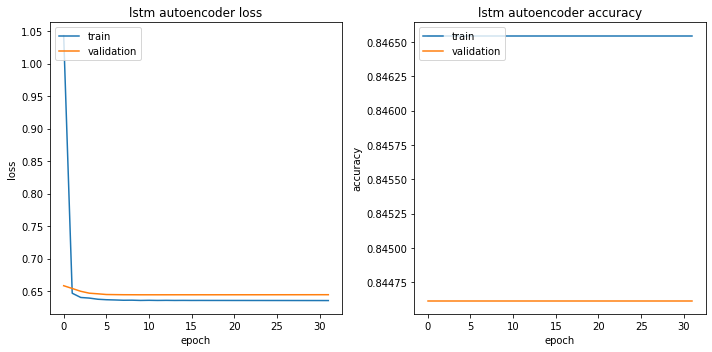

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [18]:
# how to reconstruct the sequence
idx_to_char = {'0':'T', '1':'N', '2':'G', '3':'C', '4':'A'}
def show_reconstructions(model, x_seq=xtrain_seq, original_data=xtrain, samples=10):
  reconstructions = recurrent_ae.predict(x_seq)
  print('The shape of reconstructions', reconstructions.shape)
  recon_softmax = np.argmax(reconstructions, axis=-1)
  for i in range(samples):
    seq = ''
    for idx in recon_softmax[i]:
      seq += idx_to_char[str(idx)]
    print()
    print('The {}-th original sequence vs after reconstruction'.format(i))
    print(original_data['seq'].iloc[i])
    print(seq)

show_reconstructions(recurrent_ae, xval_seq, xval)

The shape of reconstructions (45, 2449, 5)

The 0-th original sequence vs after reconstruction
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [19]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (179, 256) (45, 256) (57, 256)


In [20]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

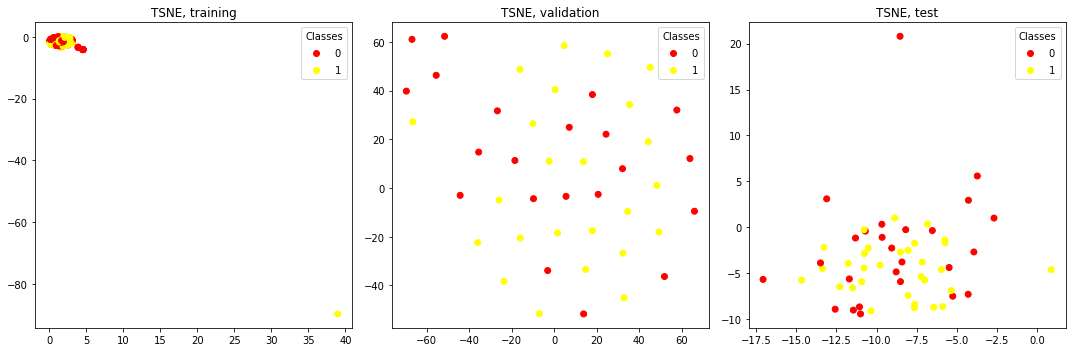

In [21]:
xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plotVec(axes[0], xtrain_tsne, ytrain, title="TSNE, training")
plotVec(axes[1], xval_tsne, yval, title="TSNE, validation")
plotVec(axes[2], xtest_tsne, ytest, title="TSNE, test")
fig.tight_layout()

In [27]:
model = keras.models.Sequential([
  keras.layers.Dense(256, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(32, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=50, callbacks=[es_cb])

Epoch 1/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.5810 - val_loss: 0.6818 - val_accuracy: 0.6222
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6145 - val_loss: 0.6816 - val_accuracy: 0.6222
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5754 - val_loss: 0.6816 - val_accuracy: 0.6222
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.6745 - accuracy: 0.5978 - val_loss: 0.6814 - val_accuracy: 0.6000
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5922 - val_loss: 0.6819 - val_accuracy: 0.5778
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5978 - val_loss: 0.6817 - val_accuracy: 0.6000
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5866 - val_loss: 0.6811 - val_accuracy: 0.6000
Epoch 8/50
6/6 [=================

In [29]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [32]:
eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval, "Validation")
eval_model(model, xtest_vec, ytest, "Test")

Training Dataset: loss = 0.668 and acccuracy = 0.615
Validation Dataset: loss = 0.67 and acccuracy = 0.6
Test Dataset: loss = 0.673 and acccuracy = 0.596


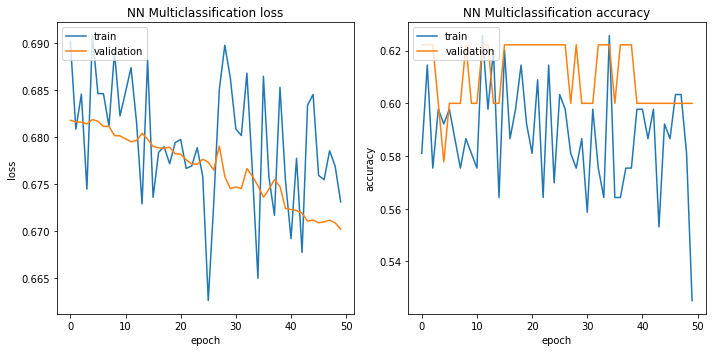

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()